# Part 2: Chest X-Ray Pneumonia detection multiclass

In [1]:
import numpy as np 
from PIL import Image 
from pathlib import Path
import pandas as pd 
import glob, os
import cv2 
import matplotlib.pyplot as plt
# default libraries for PyTorch
import torch 
import torch.nn as nn
import torch.nn.functional as F 
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

**Data directories**

In [ ]:
# data locations
train_data_loc = '../Kaggle/chest_xray/chest_xray/train'
test_data_loc = '../Kaggle/chest_xray/chest_xray/test'
val_data_loc = '../Kaggle/chest_xray/chest_xray/val'
path_train_normal = train_data_loc + '/NORMAL'
path_train_pneumonia = train_data_loc + '/PNEUMONIA'
path_test_normal = test_data_loc + '/NORMAL'
path_test_pneumonia = test_data_loc + '/PNEUMONIA'
path_val_normal = val_data_loc + '/NORMAL'
path_val_pneumonia = val_data_loc + '/PNEUMONIA'

**Extract file info**

In [3]:
def get_file_info(dir_path, extension, label):
    """ 
    - Scans directory for specific file types per extensions and returns a list of dictionaries
    - Args : 
    dir_path(string): the path to the target files
    extensions(list): list containing file extensions (i.e., .png)
    returns: 
    list: a list of dictionaries , where each dictionaries containes 
         the files path, file size, file name,types, and dimensions for each image file found 
    """
    file_info_list = []

    for ext in extension:
        # construct search pattern for glob
        search_pattern = os.path.join(dir_path,f"**/*{ext}")
        # use glob.iglob for recursive search 
        for file_path in glob.iglob(search_pattern,recursive=True):
            try:
                file_size = os.path.getsize(file_path)/1024 # in KB
                # get absolute path
                abs_path = os.path.abspath(file_path)
                # get file name
                #base_name = os.path.basename(file_path).lower()
                # get file extension 
                base_name, sufix = os.path.splitext(file_path)
                base_name = base_name.lower()
                # assign image label class
                if 'normal' in base_name:
                    type = 'normal'
                elif 'virus' in base_name:
                    type = 'virus'
                elif 'bacteria' in base_name:
                    type = 'bacteria'
                else:
                    type = 'unknown'
                
                # use pillow to get image information
                with Image.open(file_path) as img:
                    width, height = img.size
                    img_mode = img.mode
                    #img_info = img.info
                # create a dictionary for the collected informations
                file_info = {
                    "img_w"         : float(width),
                    "img_h"         : float(height),
                    "aspect ratio"  : round(float(width/height),2),
                    "file_size"     : file_size,
                    "img_mode"      : img_mode,
                    #"img_info"  : img_info,
                    "imagelabel"        : type,
                    #"filename"  : base_name,
                    "extension" : sufix,
                    "file_path" : abs_path,
                    "label"     : label,
                }
                file_info_list.append(file_info)
            except Exception as e:
                print(f"Error processing file: {file_path} : {e}")
    return file_info_list

<pre>Although creating a dataframe is not strictly necessary for this workflow, 
I created it to get an idea about the dataset, their naming styles etc.</pre>

In [4]:
extensions = [".png",".jpg",".bmp",".jpeg"]
#train_normal_path = '/Volumes/Aether/AI_ML_Projects/Kaggle/Chest_XRay_datasets/Kaggle/chest_xray/chest_xray/train/NORMAL'
#train_pneumonia_path = '/Volumes/Aether/AI_ML_Projects/Kaggle/Chest_XRay_datasets/Kaggle/chest_xray/chest_xray/train/PNEUMONIA'
train_df_normal = pd.DataFrame(get_file_info(path_train_normal,extension=extensions,label='normal'))
train_df_pneumonia = pd.DataFrame(get_file_info(path_train_pneumonia,extension=extensions,label='pneumonia'))
print(train_df_normal.shape, train_df_pneumonia.shape)

(1341, 9) (3875, 9)


**Setup and data loading**

In [3]:

# Dataset class 
class ChestXRayDataset(Dataset):
    def __init__(self,normal_dir,pneumonia_dir,transform=None, img_size=(224,224)):
        """ 
        Args: 
        - normal_dir(str): Directory with normal chest x-ray images
        - pneumonia_dir(str): Dierctory with normal chest x-ray images
        - transform (callable, optional): Optional transform to be applied on a sample
        - img_size(tuple) : Target image size (width, height) 
        Returns:
         - image and labels
        """
        self.transform = transform
        self.img_size = img_size

        # collect file path and labels
        self.file_paths = []
        self.labels = []

        # normal images (label 0)
        if os.path.exists(normal_dir):
            for filename in os.listdir(normal_dir):
                if (not filename.startswith('.')) and filename.lower().endswith(('.png','.jpeg','.jpg')):
                    self.file_paths.append(os.path.join(normal_dir, filename))
                    self.labels.append(0) # 0 for normal
        # pneumonia images labels : virus(1), bacteria(2) 
        if os.path.exists(pneumonia_dir):
            for filename in os.listdir(pneumonia_dir):
                if (not filename.startswith('.')) and filename.lower().endswith(('.png','.jpg','.jpeg')) and 'virus' in filename:
                    self.file_paths.append(os.path.join(pneumonia_dir,filename))
                    self.labels.append(1) # 1 virus
                elif (not filename.startswith('.')) and filename.lower().endswith(('.png','.jpeg','.jpg')) and 'bacteria' in filename:
                    self.file_paths.append(os.path.join(pneumonia_dir, filename))
                    self.labels.append(2) # 2 bacteria

        # simple count verification 
        normal_count = self.labels.count(0)
        virus_count = self.labels.count(1)
        bacteria_count = self.labels.count(2)
        print(f"Loaded {len(self.file_paths)} total images.")
        print(f"Breakdown, Normal: {normal_count}, Virus: {virus_count}, Bacteria:{bacteria_count}")

    def __len__(self):
        return len(self.file_paths)
        
    def __getitem__(self,idx):
        img_path = self.file_paths[idx]
        label = self.labels[idx]
        # load images 
        image = Image.open(img_path).convert('RGB') # convert to RGB to be compatible with transfer learning
        # Apply transforms
        if self.transform: 
            image = self.transform(image)
        return image, label


**Data transformation**

In [4]:

#ImageNet Mean and Std for 3-channel input
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
train_transform = transforms.Compose([
    transforms.Resize((224,224)), # (height,width)
    #transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    # data augmentation block
    transforms.RandomHorizontalFlip(p=0.5), # Data augmentation
    transforms.RandomRotation(5), # Data augmentation
    # geometric transforms
    transforms.RandomAffine(degrees=0.04, translate=(0.1,0.1),shear=1.5),
    # Color transforms
    transforms.ColorJitter(brightness=0.2,contrast=0.2),
    transforms.Normalize(mean = IMAGENET_MEAN ,std= IMAGENET_STD)
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)) ,
    #transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN,std=IMAGENET_STD)
])

val_transform = transforms.Compose([
    transforms.Resize((224,224)) ,
    #transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN,std=IMAGENET_STD)

])

**Dataloader with Train/val split**

In [5]:
#normal_dir,pneumonia_dir,transform=None, img_size=(224,224)


full_train_dataset = ChestXRayDataset(
    normal_dir   = path_train_normal,
    pneumonia_dir = path_train_pneumonia,
    transform     = train_transform,
    
)

test_dataset = ChestXRayDataset(
    normal_dir = path_test_normal,
    pneumonia_dir = path_test_pneumonia,
    transform = test_transform
)





Loaded 5216 total images.
Breakdown, Normal: 1341, Virus: 1345, Bacteria:2530
Loaded 624 total images.
Breakdown, Normal: 234, Virus: 148, Bacteria:242


**Very small validation dataset**

- I will use 10% of the train dataset as validation set. This split will be Stratified

In [6]:
from sklearn.model_selection import train_test_split

# list of all labels from the custon dataset class: ChestXRayDataset()
all_labels = np.array(full_train_dataset.labels)

# Array of indices corresponding to the full dataset
indices = np.arange(len(full_train_dataset)) 

# stratified split 

train_indices, val_indices, _, _ = train_test_split(
    indices,
    all_labels,
    test_size = 0.1, # 10% for validation 
    random_state= 42,
    stratify = all_labels
)

**Stratified Train and Validation set**

In [7]:
from torch.utils.data import Subset

# New stratified datasets 

train_dataset = Subset(full_train_dataset,train_indices)
val_dataset = Subset(full_train_dataset, val_indices)

print(f"New Training set Size:{len(train_dataset)}")
print(f"New Validation set Size:{len(val_dataset)} ")

New Training set Size:4694
New Validation set Size:522 


**Class labels in Train and Validation set**

In [8]:


def get_class_counts(dataset_subset, class_map={0: 'Normal', 1: 'Virus', 2: 'Bacteria'}):
    """
    Retrieves the counts of each class within a PyTorch Subset object.
    
    Args:
        dataset_subset (torch.utils.data.Subset): The training or validation subset.
        class_map (dict): Maps numerical labels to human-readable names.
        
    Returns:
        dict: A dictionary showing the count for each class.
    """

    full_labels = np.array(dataset_subset.dataset.labels)
    
    subset_labels = full_labels[dataset_subset.indices]
    unique_labels, counts = np.unique(subset_labels, return_counts=True)
    counts_dict = {class_map[label]: count for label, count in zip(unique_labels, counts)}
    return counts_dict

train_counts = get_class_counts(train_dataset)
print(f"Training set count:{train_counts}")
val_counts = get_class_counts(val_dataset)
print(f"validation set count: {val_counts}")

Training set count:{'Normal': np.int64(1207), 'Virus': np.int64(1210), 'Bacteria': np.int64(2277)}
validation set count: {'Normal': np.int64(134), 'Virus': np.int64(135), 'Bacteria': np.int64(253)}


**Sampler for train loader to address class imbalance between Bacteria and Virus while loading**

- This part of the work flow has been implement after running the Resnet-18 and Resnet-34 with an unsatifactory test accuracy(~82%).
- Later this sampling method while loading trainng dataset did not turnout to be improving the model performance .

In [ ]:
#from torch.utils.data.sampler import WeightedRandomSampler

""" 
inverse_freq_weights = {
    0 : 1.0/ train_counts['Normal'],
    1 : 1.0 / train_counts['Virus'],
    2 : 1.0 / train_counts['Bacteria'],

}

print(f"Invers Frequency Weights(for Sampler): {inverse_freq_weights}")

# --- Maping weights to every single sample in the training set ---

full_labels = np.array(train_dataset.dataset.labels)
# Using subset's indices to get the labels for the training set only

train_labels = full_labels[train_dataset.indices]

# List of each elements from train dataset and its corresponding weight per label 

sample_weigths = [
    inverse_freq_weights[label] for label in train_labels
]

# list to PyTorch tensor
sample_weigths_tensors = torch.as_tensor(sample_weigths, dtype=torch.double)

# The sampler
sampler = WeightedRandomSampler(
    weights = sample_weigths_tensors,
    num_samples = len(sample_weigths_tensors),
    replacement = True # Must be True for WeightedRandomSampler to draw more than once
)

train_loader = DataLoader(
    dataset = train_dataset,
    batch_size = 32,
    sampler = sampler,
    num_workers = 0,
    #pin_memory = True,
    shuffle= False,
                          )

"""





Invers Frequency Weights(for Sampler): {0: np.float64(0.0008285004142502071), 1: np.float64(0.0008264462809917355), 2: np.float64(0.0004391743522178305)}


**Train, Validation, and Test dataset loader**

In [9]:
# implement data loader
 
train_loader = DataLoader(train_dataset,batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

print(f"Train:{len(train_dataset)}, Validation:{len(val_dataset)}, Test:{len(test_dataset)}") 



Train:4694, Validation:522, Test:624


**Class weight calculation**


$weight_{i} = \frac{Total Samples}{Number \ of \ classes \times Smaples \ in \ class_{i}}$

- $N_{Total}$ : Total number of training samples.
- $N_{class_0}$(Normal): Samples in normal class.
- $N_{class_1}$(virus): Samples in the virus class. 
- $N_{class_2}$(bacteria): Samples in the bacteria class.


In [10]:
# Train class weight 

train_class_values = train_counts.values()
total_samples = sum(value for value in train_class_values )

class_weight_normal = round(total_samples /(3 * train_counts['Normal']), 3)
class_weight_virus = round(total_samples / (3 * train_counts['Virus']), 3)
class_weight_bacteria = round(total_samples / (3 * train_counts['Bacteria']), 3)

print(f"Normal class weight: {class_weight_normal}, Virus class weight: {class_weight_virus}, Bacteria class weight: {class_weight_bacteria}")

Normal class weight: 1.296, Virus class weight: 1.293, Bacteria class weight: 0.687


**get the available device function**

In [11]:
def get_device(): 
    if torch.cuda.is_available():
        device = torch.device('cuda')
    elif torch.backends.mps.is_available(): # apple silicon
        device = torch.device('mps')
    else:
        device = torch.device('cpu')
    print(f"Using the available device as: {device}")
    return device 

**model train eval function**

In [12]:
# evaluation function

device = get_device()
def eval_model(model,data_loader, device, criterion=None):
    """  
    Evaluates CNN model using give model and test dataset.
    Args : 
    - model(nn.Module) : model to evalute.
    - test_loader(DataLoader) : test dataset loader
    - criterion(nn.Module, optional): Calculates loss
    - device : CPU or GPU device based on the availablility
    Returns : 
    - Dict : A dictionary containing evaluation metrics(e.g., accuracy, loss) 
    """
   
    total_loss = 0.0
    all_preds = []
    all_labels = []
    #all_preds_scores = []

    model.to(device)
    model.eval()
    with torch.no_grad(): # disabled gradient calculation
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
        
            if criterion:
                loss = criterion(outputs,labels)
                total_loss += loss.item() * inputs.size(0)

            _ , predicted = torch.max(outputs.data,1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    # loss metric calculations
    avg_loss = total_loss / len(data_loader.dataset) if criterion else None
    accuracy = accuracy_score(all_labels,all_preds)
    # Example of other metrics (can be added as needed)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    metrics = {
        "accuracy" : accuracy,
        "precision" : precision,
        "recall"    : recall,
        "F1_score"        : f1

    }
    if avg_loss is not None: 
        metrics["loss"] = avg_loss
    print(f"Eval Accuracy: {100*accuracy:.4f}%, Weighted Precision: {precision:.4f}, Weighted Recall: {recall:.4f}")
    return metrics 
    


# train function

def train_model(model, train_loader, val_loader, device, criterion, optimizer, epochs=5, 
                 schedule=True, scheduler_type='step', print_lr=True):
    """   
    trains model with early stoping and scheduler .
    Args: 
    - model(nn.Module): CNN model.
    - train_loader(nn.Module): train data loader.
    - val_loader(nn.Module) : validation data loader.
    - critetion : nn.CrossEntropyLoss().
    - optimizer : PyTroch optim function.
    Returns: 
    list : A history list containing validation metrics
    """
    
       
    # Move model to the selected device
    model.to(device)
    best_val_loss = float('inf')
    best_model_path = './best_model_xray_multiclass.pth'
    patience = 5 
    epochs_no_improve = 0
    # ... Scheduler setup...
    if schedule:
        if scheduler_type == 'step':
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
        elif scheduler_type == 'cosine':
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
        elif scheduler_type == 'plateau':
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)
        else:
            scheduler = None
    else:
        scheduler = None
    
    history = {'train_loss': [], 'val_loss': [], 'val_accuracy': []}

    for epoch in range(epochs):
        # --- Training Phase ---
        model.train() # Set model to training mode
        running_loss = 0.0
        for batch_idx, (data, targets) in enumerate(train_loader):
            data = data.to(device)
            targets = targets.to(device)
            
            outputs = model(data)
            loss = criterion(outputs, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        
        avg_train_loss = running_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        # --- Validation Phase ---
        # Call the evaluation function using the validation data loader
        # pass the same criterion used for training to get validation loss
        val_metrics = eval_model(model, val_loader, device=device,criterion=criterion)
        avg_val_loss = val_metrics['loss']
        val_accuracy = val_metrics['accuracy']
        
        history['val_loss'].append(avg_val_loss)
        history['val_accuracy'].append(val_accuracy)
        # --Early stopping snd model saving--

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            # save the model
            torch.save(model.state_dict(),best_model_path)
            print(f"--> New best model saved at Epoch {epoch+1} with Val Loss: {best_val_loss:.4f}")
        else:
            epochs_no_improve += 1
            print(f"No improvement for {epochs_no_improve} epochs.")
            # Check if early stopping criteria met
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}!")
                break # Exit the training loop early

        # --- Scheduler Step (using validation metric if required) ---
        if scheduler:
            if scheduler_type == 'plateau':
                # Step the plateau scheduler based on the validation loss
                scheduler.step(avg_val_loss)  
            else:
                # Other schedulers step after the epoch finishes
                scheduler.step()          
        
        # --- Print Results ---
        if print_lr and schedule:
            current_lr = optimizer.param_groups[0]['lr']
            print(f'Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy*100:.2f}% | LR: {current_lr:.6f}')
        else:
            print(f'Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy*100:.2f}%')
    # Load the best model weights found during training before returning
    try:
        model.load_state_dict(torch.load(best_model_path))
        print("model updated with the lowest val loss")
    except FileNotFoundError:
        print("Best model file was not found. Returning model from final epoch.")
    return history

Using the available device as: mps


## Resnet-18

In [27]:
import torchvision.models as models
class ResNetXRay_RGB(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        # Use pretrained ResNet channel 3 (trained on ImageNet)
        self.backbone = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        for param in self.backbone.parameters():
                param.requires_grad = False
        # Modify first conv layer for grayscale (1 channel vs 3)
        #self.backbone.conv1 = nn.Conv2d(1, 64, kernel_size=(7,7), stride=(2,2), padding=(3,3), bias=False)
        
        # Modify final layer for 3 classes
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(num_features, num_classes)
    
    def forward(self, x):
        return self.backbone(x)

# model initialize 
resnet_model_RGB = ResNetXRay_RGB()

**Optimizer and Criterion: resnet-18**

In [28]:
class_weights = torch.tensor([class_weight_normal,class_weight_virus, class_weight_bacteria],dtype=torch.float32)
device = get_device()
class_weights = class_weights.to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
print(f"CrossEntropyLoss initialized with weights:{class_weights}")
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, resnet_model_RGB.parameters()), lr=0.001,weight_decay=1e-4)

Using the available device as: mps
CrossEntropyLoss initialized with weights:tensor([1.2960, 1.2930, 0.6870], device='mps:0')


**Training model**

In [18]:
train_model?

Signature:
train_model(
    model,
    train_loader,
    val_loader,
    device,
    criterion,
    optimizer,
    epochs=5,
    schedule=True,
    scheduler_type='step',
    print_lr=True,
)
Docstring:
trains model with early stoping and scheduler .
Args: 
- model(nn.Module): CNN model.
- train_loader(nn.Module): train data loader.
- val_loader(nn.Module) : validation data loader.
- critetion : nn.CrossEntropyLoss().
- optimizer : PyTroch optim function.
Returns: 
list : A history list containing validation metrics
File:      /var/folders/hf/79z0gw250v93whn49815s_gm0000gn/T/ipykernel_4171/4132188542.py
Type:      function

In [29]:
train_model(resnet_model_RGB,train_loader,val_loader,device,criterion,optimizer,schedule='plateau',epochs=20)

Eval Accuracy: 72.4138%, Weighted Precision: 0.7316, Weighted Recall: 0.7241
--> New best model saved at Epoch 1 with Val Loss: 0.6294
Epoch 1/20 | Train Loss: 0.7103 | Val Loss: 0.6294 | Val Acc: 72.41% | LR: 0.001000
Eval Accuracy: 71.2644%, Weighted Precision: 0.7345, Weighted Recall: 0.7126
--> New best model saved at Epoch 2 with Val Loss: 0.5725
Epoch 2/20 | Train Loss: 0.5893 | Val Loss: 0.5725 | Val Acc: 71.26% | LR: 0.001000
Eval Accuracy: 69.7318%, Weighted Precision: 0.7641, Weighted Recall: 0.6973
No improvement for 1 epochs.
Epoch 3/20 | Train Loss: 0.5844 | Val Loss: 0.5798 | Val Acc: 69.73% | LR: 0.001000
Eval Accuracy: 77.5862%, Weighted Precision: 0.7837, Weighted Recall: 0.7759
--> New best model saved at Epoch 4 with Val Loss: 0.5412
Epoch 4/20 | Train Loss: 0.5562 | Val Loss: 0.5412 | Val Acc: 77.59% | LR: 0.001000
Eval Accuracy: 69.5402%, Weighted Precision: 0.7573, Weighted Recall: 0.6954
No improvement for 1 epochs.
Epoch 5/20 | Train Loss: 0.5406 | Val Loss: 0.5

{'train_loss': [0.710338812904293,
  0.5892645384178681,
  0.5843847568343286,
  0.5562022498675755,
  0.5406335026633983,
  0.519539459222028,
  0.4964835828258878,
  0.5062394215136158,
  0.5078402400827732,
  0.5242746956899863,
  0.5091514493129692],
 'val_loss': [0.6293897323909847,
  0.5724861330684574,
  0.5798018147662225,
  0.5412440937140892,
  0.5707483532556629,
  0.5197540715736447,
  0.5554130753338109,
  0.5421771718852821,
  0.575575621192026,
  0.5798725718739389,
  0.5772992670536041],
 'val_accuracy': [0.7241379310344828,
  0.7126436781609196,
  0.6973180076628352,
  0.7758620689655172,
  0.6954022988505747,
  0.7279693486590039,
  0.6896551724137931,
  0.7260536398467433,
  0.6743295019157088,
  0.6743295019157088,
  0.6954022988505747]}

In [20]:
eval_model?

Signature: eval_model(model, data_loader, device, criterion=None)
Docstring:
Evaluates CNN model using give model and test dataset.
Args : 
- model(nn.Module) : model to evalute.
- test_loader(DataLoader) : test dataset loader
- criterion(nn.Module, optional): Calculates loss
- device : CPU or GPU device based on the availablility
Returns : 
- Dict : A dictionary containing evaluation metrics(e.g., accuracy, loss) 
File:      /var/folders/hf/79z0gw250v93whn49815s_gm0000gn/T/ipykernel_4171/4132188542.py
Type:      function

In [30]:
eval_model(resnet_model_RGB, test_loader, device, criterion=criterion)

Eval Accuracy: 79.4872%, Weighted Precision: 0.8267, Weighted Recall: 0.7949


{'accuracy': 0.7948717948717948,
 'precision': 0.8267284673156161,
 'recall': 0.7948717948717948,
 'loss': 0.5485729349729342}

**Test accuracy did not improve, used the following variations:**

- switched training scheduler to 'plateau' from step
- tried two different lr = 0.001 and lr=0.0001. With the second learning rate , model learns slower but no other favorable outcome. 
- trained for longer (epochs=20) but early stopping kicked in at epoch 13 .

## Resnet-34

In [19]:
import torchvision.models as models
class ResNet34XRay(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        # Use pretrained ResNet channel 3 (trained on ImageNet)
        self.backbone = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
        # All layers intially frozen
        for param in self.backbone.parameters():
                param.requires_grad = False

        # Unfreezing layers 4 
        #for param in self.backbone.layer3.parameters():
        #    param.requires_grad = True
        for param in self.backbone.layer4.parameters():
             param.requires_grad = True
        
        # Modify final layer for 3  classes
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(num_features, num_classes)
    
    def forward(self, x):
        return self.backbone(x)
    
# Resnet-34 initialization   
model_resnet34 = ResNet34XRay()

In [20]:
device = get_device()
class_weights = torch.tensor([class_weight_normal,class_weight_virus, class_weight_bacteria],dtype=torch.float32).to(device)
#class_weights = torch.tensor([1.2, 1.2, 0.8], dtype=torch.float32).to(device)
#class_weights = torch.tensor([1.3, 1.3, 0.7], dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
print(f"CrossEntropyLoss initialized with weights:{class_weights}")

# differential learning rate for optimizer
#backbone_l3_params = [{'params':model_resnet34.backbone.layer3.parameters(),'lr':3e-6}]
backbone_l4_params = [{'params':model_resnet34.backbone.layer4.parameters(),'lr':1e-5}]
classifier_params = [{'params':model_resnet34.backbone.fc.parameters(),'lr':1e-3}] 

optimizer_parameter = backbone_l4_params + classifier_params

optimizer = torch.optim.Adam(optimizer_parameter, lr= 1e-3,weight_decay=0.5e-3) 
# You can check the learning rates:
print(f"Layer 4 LR: {optimizer.param_groups[0]['lr']}")
print(f"FC Layer LR: {optimizer.param_groups[1]['lr']}")

Using the available device as: mps
CrossEntropyLoss initialized with weights:tensor([1.2960, 1.2930, 0.6870], device='mps:0')
Layer 4 LR: 1e-05
FC Layer LR: 0.001


In [21]:
train_model(model_resnet34,train_loader,val_loader,device,criterion,optimizer,schedule='plateau',epochs=20)

Eval Accuracy: 69.5402%, Weighted Precision: 0.7532, Weighted Recall: 0.6954
--> New best model saved at Epoch 1 with Val Loss: 0.5666
Epoch 1/20 | Train Loss: 0.6473 | Val Loss: 0.5666 | Val Acc: 69.54% | LR: 0.000010
Eval Accuracy: 76.8199%, Weighted Precision: 0.7804, Weighted Recall: 0.7682
--> New best model saved at Epoch 2 with Val Loss: 0.4758
Epoch 2/20 | Train Loss: 0.5319 | Val Loss: 0.4758 | Val Acc: 76.82% | LR: 0.000010
Eval Accuracy: 80.4598%, Weighted Precision: 0.7978, Weighted Recall: 0.8046
No improvement for 1 epochs.
Epoch 3/20 | Train Loss: 0.4959 | Val Loss: 0.5017 | Val Acc: 80.46% | LR: 0.000010
Eval Accuracy: 80.2682%, Weighted Precision: 0.8145, Weighted Recall: 0.8027
--> New best model saved at Epoch 4 with Val Loss: 0.4714
Epoch 4/20 | Train Loss: 0.4615 | Val Loss: 0.4714 | Val Acc: 80.27% | LR: 0.000010
Eval Accuracy: 79.6935%, Weighted Precision: 0.7955, Weighted Recall: 0.7969
--> New best model saved at Epoch 5 with Val Loss: 0.4679
Epoch 5/20 | Train

{'train_loss': [0.6472595068467718,
  0.5319071317813835,
  0.49591797934908444,
  0.46149328330747125,
  0.4518977091425941,
  0.40465008634693767,
  0.40888742534887224,
  0.4144122512364874,
  0.40163035569142325,
  0.4000137687540379,
  0.4007595269655695,
  0.40779012593687797,
  0.39956487593602164],
 'val_loss': [0.5665751750441803,
  0.4758362356730348,
  0.5017447389976275,
  0.47141036368421213,
  0.46792701012330035,
  0.42762628037810785,
  0.43457838493288703,
  0.41080280396216673,
  0.4109578932496323,
  0.4355206240639376,
  0.4492121062516253,
  0.4414082750735155,
  0.46346440694341257],
 'val_accuracy': [0.6954022988505747,
  0.7681992337164751,
  0.8045977011494253,
  0.8026819923371648,
  0.7969348659003831,
  0.8103448275862069,
  0.8275862068965517,
  0.8122605363984674,
  0.8256704980842912,
  0.8199233716475096,
  0.8199233716475096,
  0.8103448275862069,
  0.8045977011494253]}

In [22]:
eval_model(model_resnet34, test_loader, device, criterion=criterion)

Eval Accuracy: 83.8141%, Weighted Precision: 0.8519, Weighted Recall: 0.8381


{'accuracy': 0.8381410256410257,
 'precision': 0.8519324553163593,
 'recall': 0.8381410256410257,
 'F1_score': 0.8390469200256016,
 'loss': 0.5714743336041769}

## Training function modification : early stopping using F1-score

*I tried to summarize a couple of experiemnts in this cell of the notebook for record keeping of my work flow and its phase*

**Experiments were done using resnet-34**
---

A confusion matrix based on the current training and evaluation shows : 

<pre>
==============================
--- Classification Report ----
==============================
              precision    recall  f1-score   support

      Normal     0.9263    0.7521    0.8302       234
       Virus     0.6875    0.8176    0.7469       148
    Bacteria     0.8566    0.9132    0.8840       242

    accuracy                         0.8301       624
   macro avg     0.8235    0.8276    0.8204       624
weighted avg     0.8426    0.8301    0.8313       624


==============================
--- Summary Metrics ---
==============================
Multi-Class AUC-ROC (Weighted): 0.9521
F1-Score (Weighted):            0.8313
</pre>
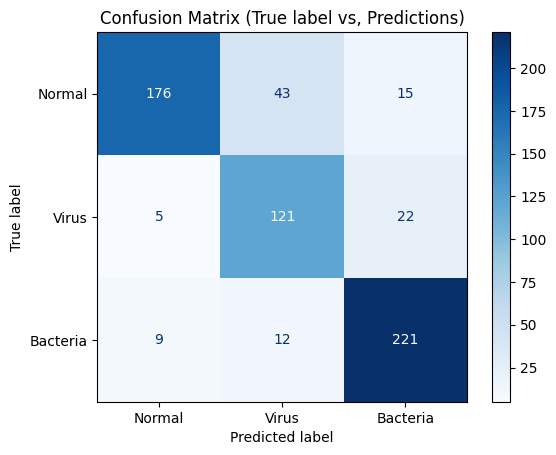

- Virus class is bottleneck in the learning process
- Low precision : many normal images are mistakenly identified as Virus.

**Experiemnts are done using Resnet-34** 

**Experiment 1 :**

1. Traning modeling and early stopping using F1 score : did not improve the model performace. 
2. Weight decay in optimizer chagning from 1e-3 to 5e-3 also did not make improvement. 
    Performance became little bit worse due to higher regularizations.


<pre>

==============================
--- Classification Report ----
==============================
              precision    recall  f1-score   support

      Normal     0.9643    0.6923    0.8060       234
       Virus     0.6629    0.7838    0.7183       148
    Bacteria     0.8007    0.9298    0.8604       242

    accuracy                         0.8061       624
   macro avg     0.8093    0.8019    0.7949       624
weighted avg     0.8294    0.8061    0.8063       624


==============================
--- Summary Metrics ---
==============================
Multi-Class AUC-ROC (Weighted): 0.9502
F1-Score (Weighted):            0.8063
---------
{'auc_weighted': 0.9502178666111055,
 'f1_weighted': 0.8062856054827953,
 'cm': array([[162,  47,  25],
               [  1, 116,  31],
                [  5,  12, 225]])}

</pre>


**Experiment 2 :**
1. Unfreeze layer 3 in the Resnet-34 . 
2. Use val_loss for traning model. 
result : model did not imporve performance or the confusion matrix did not improve .

**Experiemnt 3:**

1. freeze layer 3 and keeping the layer 4 unfrozen for learning (1e-5)
2. decrease regulirazion by setting the weight_decay=0.5e-3. 
result : appears to a bit better than before . 

<pre>
==============================
--- Classification Report ----
==============================
              precision    recall  f1-score   support

      Normal     0.9516    0.7564    0.8429       234
       Virus     0.7052    0.8243    0.7601       148
    Bacteria     0.8453    0.9256    0.8836       242

    accuracy                         0.8381       624
   macro avg     0.8340    0.8355    0.8289       624
weighted avg     0.8519    0.8381    0.8390       624


==============================
--- Summary Metrics ---
==============================
Multi-Class AUC-ROC (Weighted): 0.9472
F1-Score (Weighted):            0.8390

{'auc_weighted': 0.9471914193199816,
 'f1_weighted': 0.8390469200256016,
 'cm': array([[177,  40,  17],
             [ 2, 122,  24],
            [  7,  11, 224]])} </pre>

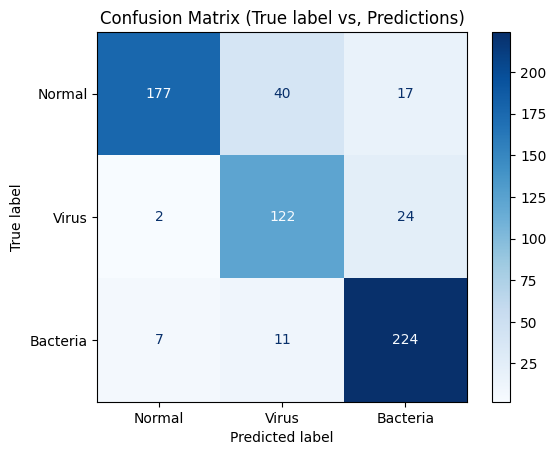






In [40]:
def train_model_f1(model, train_loader, val_loader, device, criterion, optimizer, epochs=5, 
                 schedule=True, scheduler_type='plateau', print_lr=True):
    """   
    trains model with early stoping using F1-score and scheduler .
    Args: 
    - model(nn.Module): CNN model.
    - train_loader(nn.Module): train data loader.
    - val_loader(nn.Module) : validation data loader.
    - critetion : nn.CrossEntropyLoss().
    - optimizer : PyTroch optim function.
    Returns: 
    list : A history list containing validation metrics
    """
           
    # Move model to the selected device
    model.to(device)
    best_val_f1 = -1.0
    best_model_path = './model_xray_multiclass_f1_stop.pth'
    patience = 5 
    epochs_no_improve = 0
    # ... Scheduler setup...
    if schedule:
        if scheduler_type == 'step':
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
        elif scheduler_type == 'cosine':
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
        elif scheduler_type == 'plateau':
            scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=2, factor=0.5)
        else:
            scheduler = None
    else:
        scheduler = None
    
    history = {'train_loss': [], 'val_loss': [], 'val_accuracy': [],'F1_score':[]}

    for epoch in range(epochs):
        # --- Training Phase ---
        model.train() # Set model to training mode
        running_loss = 0.0
        for batch_idx, (data, targets) in enumerate(train_loader):
            data = data.to(device)
            targets = targets.to(device)
            
            outputs = model(data)
            loss = criterion(outputs, targets)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        
        avg_train_loss = running_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        # --- Validation Phase ---
        # Call the evaluation function using the validation data loader
        # pass the same criterion used for training to get validation loss
        val_metrics = eval_model(model, val_loader, device=device,criterion=criterion)
        avg_val_loss = val_metrics['loss']
        val_accuracy = val_metrics['accuracy']
        val_F1 = val_metrics['F1_score']
        
        history['val_loss'].append(avg_val_loss)
        history['val_accuracy'].append(val_accuracy)
        history['F1_score'].append(val_F1)
        # --Early stopping snd model saving--

        if val_F1 > best_val_f1:
            best_val_f1 = val_F1
            epochs_no_improve = 0
            # save the model
            torch.save(model.state_dict(),best_model_path)
            print(f"--> New best model saved at Epoch {epoch+1} with Val F1: {best_val_f1:.4f}")
        else:
            epochs_no_improve += 1
            print(f"No improvement for {epochs_no_improve} epochs.")
            # Check if early stopping criteria met
            if epochs_no_improve >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}!")
                break # Exit the training loop early

        # --- Scheduler Step (using validation metric if required) ---
        if scheduler:
            if scheduler_type == 'plateau':
                # Step the plateau scheduler based on the validation loss
                scheduler.step(val_F1)  
            else:
                # Other schedulers step after the epoch finishes
                scheduler.step()          
        
        # --- Print Results ---
        if print_lr and schedule:
            current_lr = optimizer.param_groups[0]['lr']
            print(f'Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy*100:.2f}% | Val F1: {val_F1:.4f} | LR: {current_lr:.6f}')
        else:
            print(f'Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy*100:.2f}%')
    # Load the best model weights found during training before returning
    try:
        model.load_state_dict(torch.load(best_model_path))
        print("model updated with the highest F1-score.")
    except FileNotFoundError:
        print("Best model file was not found. Returning model from final epoch.")
    return history
    

In [ ]:
#train_model_f1(model_resnet34, train_loader, val_loader, device, criterion, optimizer, epochs=20, 
#                schedule=True, scheduler_type='plateau', print_lr=True)

Eval Accuracy: 76.8199%, Weighted Precision: 0.7749, Weighted Recall: 0.7682
--> New best model saved at Epoch 1 with Val F1: 0.7699
Epoch 1/20 | Train Loss: 0.6614 | Val Loss: 0.5099 | Val Acc: 76.82% | Val F1: 0.7699 | LR: 0.000010
Eval Accuracy: 72.4138%, Weighted Precision: 0.7850, Weighted Recall: 0.7241
No improvement for 1 epochs.
Epoch 2/20 | Train Loss: 0.5277 | Val Loss: 0.5176 | Val Acc: 72.41% | Val F1: 0.7286 | LR: 0.000010
Eval Accuracy: 80.6513%, Weighted Precision: 0.8110, Weighted Recall: 0.8065
--> New best model saved at Epoch 3 with Val F1: 0.7895
Epoch 3/20 | Train Loss: 0.4922 | Val Loss: 0.5108 | Val Acc: 80.65% | Val F1: 0.7895 | LR: 0.000010
Eval Accuracy: 79.8851%, Weighted Precision: 0.8150, Weighted Recall: 0.7989
--> New best model saved at Epoch 4 with Val F1: 0.8013
Epoch 4/20 | Train Loss: 0.4711 | Val Loss: 0.4426 | Val Acc: 79.89% | Val F1: 0.8013 | LR: 0.000010
Eval Accuracy: 77.9693%, Weighted Precision: 0.8051, Weighted Recall: 0.7797
No improvement

{'train_loss': [0.6614087313210884,
  0.5277434367509115,
  0.4921969584867257,
  0.47113373510691586,
  0.46735244249405505,
  0.4324509111188707,
  0.4287148127142264,
  0.3975154854813401,
  0.3930223778802521,
  0.3968168083502322,
  0.3923505775782527,
  0.3759566400529576,
  0.34565049156445227,
  0.3501892336169068,
  0.33990225297253146,
  0.33253154107908,
  0.32777185768497236,
  0.3100291772359082,
  0.3152442542569978],
 'val_loss': [0.5099042016884376,
  0.5176453813054096,
  0.5108323595647154,
  0.44256501847528407,
  0.4838617246498093,
  0.4589531564392806,
  0.4309227508831755,
  0.4877970368240985,
  0.460191289583842,
  0.44376890760957055,
  0.44122058153152466,
  0.4338481073406921,
  0.41715643723349005,
  0.43719179705641736,
  0.4255066999730251,
  0.4244739983045278,
  0.443046441708488,
  0.42006447443103423,
  0.4032725244189588],
 'val_accuracy': [0.7681992337164751,
  0.7241379310344828,
  0.8065134099616859,
  0.7988505747126436,
  0.7796934865900383,
  0

In [42]:
eval_model(model_resnet34, test_loader, device, criterion=criterion)

Eval Accuracy: 80.6090%, Weighted Precision: 0.8294, Weighted Recall: 0.8061


{'accuracy': 0.8060897435897436,
 'precision': 0.8293556991644179,
 'recall': 0.8060897435897436,
 'F1_score': 0.8062856054827953,
 'loss': 0.639741586186947}

**model validation : classification report and confusion matrix** 

In [24]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

def validate_model_multiclass(model, val_loader, device, class_names=['Normal','Virus','Bacteria']):
    """ 
    Evaluate a 3-class CNN model and generate a classification report and confusion matrix.
    Args:
        -model(nn.Module): The trained CNN model.
        - val_loader(Dataloader): validation or test data loader.
        - device(torch.device) : returned available device from the function get_device(). 
        - class_names(list) : List of class names corresponding to labels : 0, 1, 2
    retunrs : 
        - dict : A dictionary containing key metrics.
    """

    model.eval() # model set in eval mode
    all_labels = []
    all_preds_score = [] # stores probabilites of all three classes 
    all_preds_classes = [] # Stores hard predictions (0,1,2)

    with torch.no_grad():

        for data, labels in val_loader:
            data = data.to(device)
            all_labels.extend(labels.cpu().numpy())

            outputs = model(data)

            #--- probability scores for AUC--
            probs = torch.softmax(outputs,dim=1)
            all_preds_score.extend(probs.cpu().numpy())
            # --- get hard prediction --- 
            _, predicted = torch.max(outputs.data, 1)
            all_preds_classes.extend(predicted.cpu().numpy())

    # Converting list to numpy array for scikit-learn --
    all_labels = np.array(all_labels)
    all_preds_score = np.array(all_preds_score)
    all_preds_classes = np.array(all_preds_classes)

    # Metrics calculations
    if len(np.unique(all_labels)) < 3 : 
        print("Warning: Less than three(3) uniques classes present. Multiclass metrics may be unreliable.")
    # --- ROC_AUC(Mutli-class: One-vs-Rest)---
    auc_weighted = roc_auc_score(all_labels,all_preds_score,multi_class='ovr',average='weighted')
    # ---F1: precision/recall balance --- 
    f1_weighted = f1_score(all_labels, all_preds_classes, average='weighted')

    # --- classification report--- 

    print("\n" + "="*30)
    print("--- Classification Report ----")
    print("="*30)
    print(classification_report(all_labels,all_preds_classes, target_names=class_names, digits=4))
    # --- confusion mentrix --- 
    cm = confusion_matrix(all_labels, all_preds_classes)
    #--- print multiclass summay metrics --  
    print("\n" + "="*30)
    print(f"--- Summary Metrics ---")
    print("="*30)
    print(f"Multi-Class AUC-ROC (Weighted): {auc_weighted:.4f}")
    print(f"F1-Score (Weighted):            {f1_weighted:.4f}")
    # --- display confusion matrix --- 
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix (True label vs, Predictions)")
    plt.show()

    return {'auc_weighted': auc_weighted, 'f1_weighted': f1_weighted, 'cm': cm}




--- Classification Report ----
              precision    recall  f1-score   support

      Normal     0.9516    0.7564    0.8429       234
       Virus     0.7052    0.8243    0.7601       148
    Bacteria     0.8453    0.9256    0.8836       242

    accuracy                         0.8381       624
   macro avg     0.8340    0.8355    0.8289       624
weighted avg     0.8519    0.8381    0.8390       624


--- Summary Metrics ---
Multi-Class AUC-ROC (Weighted): 0.9472
F1-Score (Weighted):            0.8390


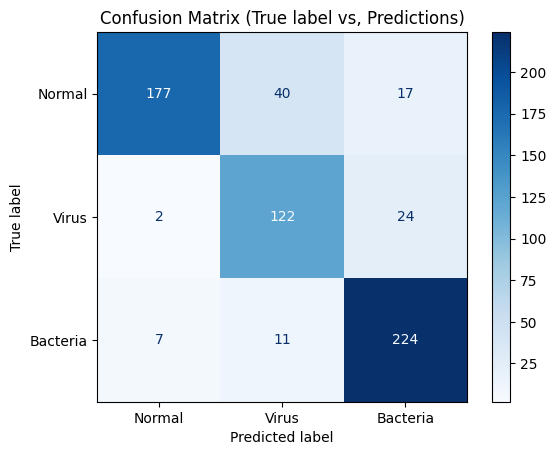

{'auc_weighted': 0.9471914193199816,
 'f1_weighted': 0.8390469200256016,
 'cm': array([[177,  40,  17],
        [  2, 122,  24],
        [  7,  11, 224]])}

In [25]:
validate_model_multiclass(model_resnet34, test_loader, device, class_names=['Normal','Virus','Bacteria'])

**TTA: Test Time Augmentation**

In [ ]:

def eval_model_tta(model, data_loader, device, criterion=None,class_names=['Normal','Virus','Bacteria'], tta=True):
    """
    Evaluates model with optional Test-Time Augmentation (TTA).
    TTA scheme: original + horizontal flip + small rotation.
    """
    model.to(device)
    model.eval()

    total_loss = 0.0
    all_preds = []
    all_labels = []
    all_preds_score = [] # stores probabilites of all three classes 
    all_preds_classes = [] # Stores hard predictions (0,1,2)

    # TTA transforms applied on-the-fly (same normalization already in data)
    def _augment_batch(x):
        # x: (B, C, H, W)
        if not tta:
            return [x]

        x_hflip = torch.flip(x, dims=[3])  # horizontal flip
        # small rotation: rotate by +5 degrees using affine
        return [x, x_hflip]  # keep it simple: original + flip

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            # collect logits from TTA views
            logits_list = []
            for x_aug in _augment_batch(inputs):
                outputs_aug = model(x_aug)
                logits_list.append(outputs_aug)

            # average logits over TTA samples
            outputs = torch.stack(logits_list, dim=0).mean(dim=0)  # (B, C)

            if criterion:
                loss = criterion(outputs, labels)
                total_loss += loss.item() * inputs.size(0)

            probs = F.softmax(outputs, dim=1)
            preds = probs.argmax(dim=1)
            all_preds_score.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            # --- get hard prediction --- 
            #_, predicted = torch.max(outputs.data, 1)
            all_preds_classes.extend(preds.cpu().numpy())

    avg_loss = total_loss / len(data_loader.dataset) if criterion else None
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    # --- ROC_AUC(Mutli-class: One-vs-Rest)---
    auc_weighted = roc_auc_score(all_labels,all_preds_score,multi_class='ovr',average='weighted')

    metrics = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "F1_score": f1,
    }
    if avg_loss is not None:
        metrics["loss"] = avg_loss

    print(f"[TTA={tta}] Acc: {accuracy*100:.2f}%, W-F1: {f1:.4f}, W-Prec: {precision:.4f}, W-Rec: {recall:.4f}")

    # --- classification report--- 

    print("\n" + "="*30)
    print("--- Classification Report ----")
    print("="*30)
    print(classification_report(all_labels,all_preds_classes, target_names=class_names, digits=4))
    # --- confusion mentrix --- 
    cm = confusion_matrix(all_labels, all_preds_classes)
    #--- print multiclass summay metrics --  
    print("\n" + "="*30)
    print(f"--- Summary Metrics ---")
    print("="*30)
    print(f"Multi-Class AUC-ROC (Weighted): {auc_weighted:.4f}")
    print(f"F1-Score (Weighted):            {f1:.4f}")
    # --- display confusion matrix --- 
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix (True label vs, Predictions)")
    plt.show()
    print("Confusion Matrix = ",cm)
    return metrics


# Resnet-50 

In [14]:
import torchvision.models as models
class ResNet50XRay(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        # Use pretrained ResNet channel 3 (trained on ImageNet)
        self.backbone = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        # All layers intially frozen
        for param in self.backbone.parameters():
                param.requires_grad = False

        # Unfreezing layers 4 
        #for param in self.backbone.layer3.parameters():
        #    param.requires_grad = True
        for param in self.backbone.layer4.parameters():
             param.requires_grad = True
        
        # Modify final layer for 3  classes
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Linear(num_features, num_classes)
    
    def forward(self, x):
        return self.backbone(x)
    
# Resnet-34 initialization   
model_resnet50 = ResNet50XRay()

**Optimizer and criterion**

In [48]:
device = get_device()
class_weights = torch.tensor([class_weight_normal,class_weight_virus, class_weight_bacteria],dtype=torch.float32).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
print(f"CrossEntropyLoss initialized with weights:{class_weights}")

# differential learning rate for optimizer
#backbone_l3_params = [{'params':model_resnet34.backbone.layer3.parameters(),'lr':3e-6}]
backbone_l4_params = [{'params':model_resnet50.backbone.layer4.parameters(),'lr':1e-5}]
classifier_params = [{'params':model_resnet50.backbone.fc.parameters(),'lr':1e-3}] 

optimizer_parameter = backbone_l4_params + classifier_params

optimizer = torch.optim.Adam(optimizer_parameter, lr= 1e-3,weight_decay=2e-3) 
# check the learning rates:
print(f"Layer 4 LR: {optimizer.param_groups[0]['lr']}")
print(f"FC Layer LR: {optimizer.param_groups[1]['lr']}")

Using the available device as: mps
CrossEntropyLoss initialized with weights:tensor([1.2960, 1.2930, 0.6870], device='mps:0')
Layer 4 LR: 1e-05
FC Layer LR: 0.001


**Train model**

In [49]:
train_model(model_resnet50,train_loader,val_loader,device,criterion,optimizer,schedule='plateau',epochs=20)

Eval Accuracy: 73.9464%, Weighted Precision: 0.7490, Weighted Recall: 0.7395
--> New best model saved at Epoch 1 with Val Loss: 0.5525
Epoch 1/20 | Train Loss: 0.7158 | Val Loss: 0.5525 | Val Acc: 73.95% | LR: 0.000010
Eval Accuracy: 78.5441%, Weighted Precision: 0.7846, Weighted Recall: 0.7854
--> New best model saved at Epoch 2 with Val Loss: 0.4968
Epoch 2/20 | Train Loss: 0.5679 | Val Loss: 0.4968 | Val Acc: 78.54% | LR: 0.000010
Eval Accuracy: 79.3103%, Weighted Precision: 0.7892, Weighted Recall: 0.7931
--> New best model saved at Epoch 3 with Val Loss: 0.4762
Epoch 3/20 | Train Loss: 0.5333 | Val Loss: 0.4762 | Val Acc: 79.31% | LR: 0.000010
Eval Accuracy: 78.7356%, Weighted Precision: 0.7918, Weighted Recall: 0.7874
No improvement for 1 epochs.
Epoch 4/20 | Train Loss: 0.5007 | Val Loss: 0.5005 | Val Acc: 78.74% | LR: 0.000010
Eval Accuracy: 77.5862%, Weighted Precision: 0.7981, Weighted Recall: 0.7759
--> New best model saved at Epoch 5 with Val Loss: 0.4747
Epoch 5/20 | Train

{'train_loss': [0.7158449498974547,
  0.5679217469530041,
  0.53329687540223,
  0.5007026256347189,
  0.4798064683975817,
  0.4573078721153493,
  0.45919517290835477,
  0.46511205341540224,
  0.45508436138938074,
  0.45426667091392336,
  0.45398569573350506],
 'val_loss': [0.5525331113530302,
  0.4968358993073533,
  0.47617103210810957,
  0.5004719308509681,
  0.4747354188412999,
  0.46915003189181914,
  0.4801172063725205,
  0.48746120838369905,
  0.5016856542949019,
  0.4724132612747251,
  0.47664514720668283],
 'val_accuracy': [0.7394636015325671,
  0.7854406130268199,
  0.7931034482758621,
  0.7873563218390804,
  0.7758620689655172,
  0.8103448275862069,
  0.7835249042145593,
  0.7758620689655172,
  0.7739463601532567,
  0.7931034482758621,
  0.8026819923371648]}

**Eval model**

In [50]:
eval_model(model_resnet50, test_loader, device, criterion=criterion)

Eval Accuracy: 84.7756%, Weighted Precision: 0.8612, Weighted Recall: 0.8478


{'accuracy': 0.8477564102564102,
 'precision': 0.8611518250231748,
 'recall': 0.8477564102564102,
 'F1_score': 0.8503511061986202,
 'loss': 0.5263046083542017}

**Classification report and Confusion Matrix**


--- Classification Report ----
              precision    recall  f1-score   support

      Normal     0.9394    0.7949    0.8611       234
       Virus     0.6906    0.8446    0.7599       148
    Bacteria     0.8898    0.9008    0.8953       242

    accuracy                         0.8478       624
   macro avg     0.8399    0.8468    0.8388       624
weighted avg     0.8612    0.8478    0.8504       624


--- Summary Metrics ---
Multi-Class AUC-ROC (Weighted): 0.9510
F1-Score (Weighted):            0.8504


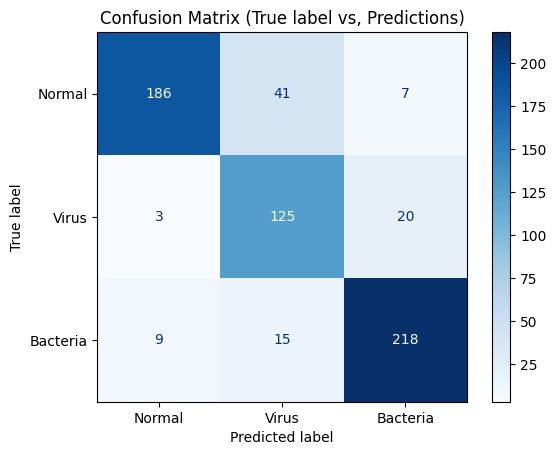

{'auc_weighted': 0.9509860172060192,
 'f1_weighted': 0.8503511061986202,
 'cm': array([[186,  41,   7],
        [  3, 125,  20],
        [  9,  15, 218]])}

In [51]:
validate_model_multiclass(model_resnet50, test_loader, device, class_names=['Normal','Virus','Bacteria'])

**TTA**

[TTA=True] Acc: 85.10%, W-F1: 0.8525, W-Prec: 0.8625, W-Rec: 0.8510

--- Classification Report ----
              precision    recall  f1-score   support

      Normal     0.9485    0.7863    0.8598       234
       Virus     0.7052    0.8243    0.7601       148
    Bacteria     0.8755    0.9298    0.9018       242

    accuracy                         0.8510       624
   macro avg     0.8430    0.8468    0.8406       624
weighted avg     0.8625    0.8510    0.8525       624


--- Summary Metrics ---
Multi-Class AUC-ROC (Weighted): 0.9554
F1-Score (Weighted):            0.8525


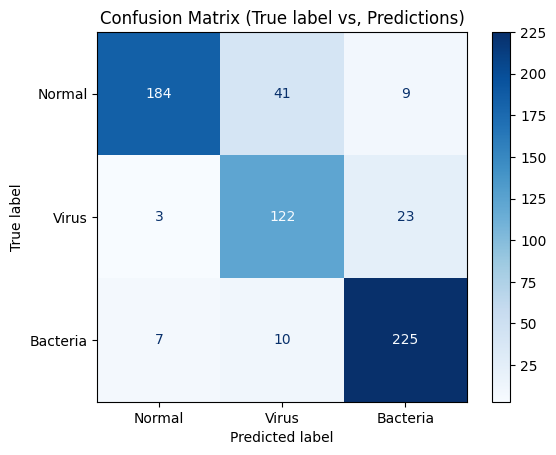

Confusion Matrix =  [[184  41   9]
 [  3 122  23]
 [  7  10 225]]


{'accuracy': 0.8509615384615384,
 'precision': 0.8624612032156799,
 'recall': 0.8509615384615384,
 'F1_score': 0.8524538092880385,
 'loss': 0.510441080117837}

In [56]:
eval_model_tta(model_resnet50, test_loader, device, criterion=criterion, tta=True)

### GRAD-CAM plot workflow

**Load saved state dictionary**


In [15]:
device = get_device()
MODEL_PATH = '../best_model/xray_multiclassResnet_50.pth'
try: 
    state_dict = torch.load(MODEL_PATH,map_location=device)
    model_resnet50.load_state_dict(state_dict)
    model_resnet50.to(device)
    model_resnet50.eval()
    print(f"Model loaded sucessfully from{MODEL_PATH} and set to evaluation mode.")
except Exception as e:
    print(e)


Using the available device as: mps
Model loaded sucessfully from../best_model/xray_multiclassResnet_50.pth and set to evaluation mode.


**Define transformation and GRAD-CAM function**

In [ ]:
# Re-define image normalization constants
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
image_resize = (224, 224) 

# Re-define the validation transform 
val_transform = transforms.Compose([
    transforms.Resize(image_resize),
    transforms.Grayscale(num_output_channels=3), 
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD) 
])

# generate grad-cam 
def generate_grad_cam(model, input_tensor, target_class=1): 
    """  
    Generates a Grad-CAM heatmap for a single input image.
    
    Args:
    - model(nn.Module): trained model(e.g., ResnetXRay_RGB)
    - input_tensor (torch.tensor): The 4D input tensor (1,C,H,W).
    - target_class(int): The index of the class to visualize(e.g., 1 for Pneumonia(Virus))
    """
    model.eval()
    feature_maps = None
    gradients = None 
    # last convolution block(layer 4)
    target_layer = model.backbone.layer4
    
    def forward_hook(module, input, output):
        nonlocal feature_maps
        feature_maps = output
    def backward_hook(module, grad_in, grad_out):
        nonlocal gradients 
        gradients = grad_out[0]

    # registering hooks on target layer
    forward_handle = target_layer.register_forward_hook(forward_hook)
    backward_handle = target_layer.register_backward_hook(backward_hook)
    # gradient for backprop
    input_tensor.requires_grad_(True)
    # forward pass and target Score
    output = model(input_tensor)
    # zero all gradients 
    model.zero_grad()
    # zero tensor for all classes except class_1
    one_hot = torch.zeros_like(output)
    one_hot[0][target_class] = 1.0 # batch size 1
    # Backpropagate the one-hot score
    output.backward(gradient=one_hot,retain_graph=True)
    # Compute Grad-CAM
    # Global average pooling of the gradients (alpha_k)
    # gradients shape: (1, 512, H, W) -> weights shape: (1, 512, 1, 1)
    weights = torch.mean(gradients,dim=(2,3),keepdim=True)
    # Compute weighted feature map (L_Grad-CAM)
    cam = torch.sum(weights * feature_maps, dim=1)
    # RelU to keep only positive influence
    cam = F.relu(cam)
    # formating 
    forward_handle.remove()
    backward_handle.remove()
    # resize to original image size 
    H,W = input_tensor.shape[2:]
    cam = F.interpolate(cam.unsqueeze(0),size=(H,W),mode='bilinear',align_corners=False)
    # normalize the heatmap to 0-1 range 
    cam = cam.detach().squeeze().cpu().numpy()
    cam = (cam-cam.min())/ (cam.max()-cam.min()+1e-8)

    return cam 


**Plot**

/Users/imrankhan/AI_ML_Projects/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
/var/folders/hf/79z0gw250v93whn49815s_gm0000gn/T/ipykernel_1793/2081349339.py:19: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  plt.figure(1,2,2)


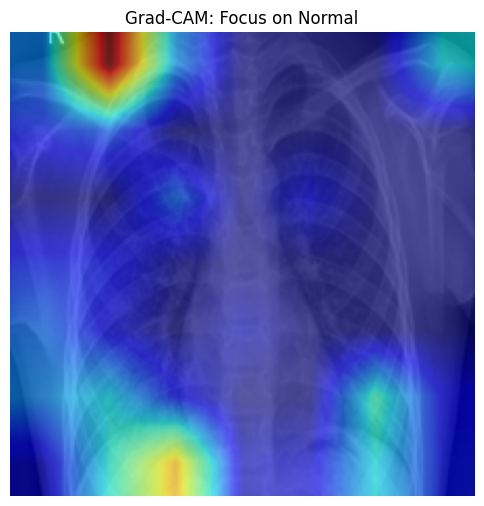

In [ ]:
# test pneumonia normal image 
normal_image = '../Kaggle/chest_xray/chest_xray/test/NORMAL/IM-0015-0001.jpeg'
raw_image = Image.open(normal_image).convert("RGB")

# input tensor
input_tensor = val_transform(raw_image).unsqueeze(0).to(device)
#heatmap 
heatmap = generate_grad_cam(model_resnet50,input_tensor, target_class=0) # class = 0 for normal
# display results
resized_raw_image = raw_image.resize(image_resize)
original_img_np = np.array(resized_raw_image)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(original_img_np)
plt.title("Original Image")
plt.axis('off')

plt.figure(1,2,2)
plt.imshow(original_img_np, alpha=1.0)
#overlay the heat map
plt.imshow(heatmap, alpha=0.6, cmap='jet')
plt.title(f"Grad-CAM: Focus on Normal")
plt.axis('off')
plt.tight_layout()
plt.show()

/Users/imrankhan/AI_ML_Projects/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)
/var/folders/hf/79z0gw250v93whn49815s_gm0000gn/T/ipykernel_1793/3810631650.py:19: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  plt.figure(1,2,2)


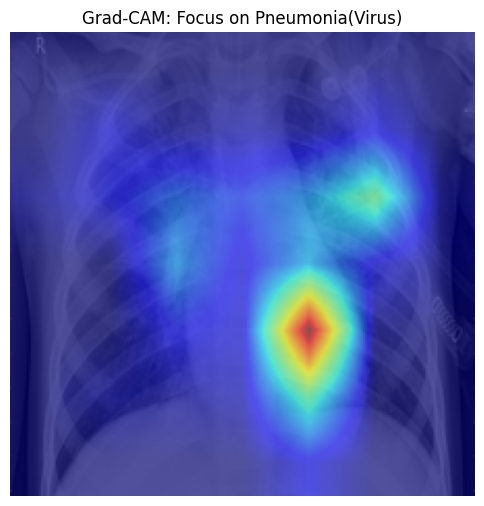

In [ ]:
# test pneumonia virus image 
pneumonia_image = '../Kaggle/chest_xray/chest_xray/test/PNEUMONIA/person3_virus_16.jpeg'
raw_image = Image.open(pneumonia_image).convert("RGB")

# input tensor
input_tensor = val_transform(raw_image).unsqueeze(0).to(device)
#heatmap 
heatmap = generate_grad_cam(model_resnet50,input_tensor, target_class=1)
# display results
resized_raw_image = raw_image.resize(image_resize)
original_img_np = np.array(resized_raw_image)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(original_img_np)
plt.title("Original Image")
plt.axis('off')

plt.figure(1,2,2)
plt.imshow(original_img_np, alpha=1.0)
#overlay the heat map
plt.imshow(heatmap, alpha=0.6, cmap='jet')
plt.title(f"Grad-CAM: Focus on Pneumonia(Virus)")
plt.axis('off')
plt.tight_layout()
plt.show()



/var/folders/hf/79z0gw250v93whn49815s_gm0000gn/T/ipykernel_1793/3227368115.py:19: UserWarning: Ignoring specified arguments in this call because figure with num: 1 already exists
  plt.figure(1,2,2)


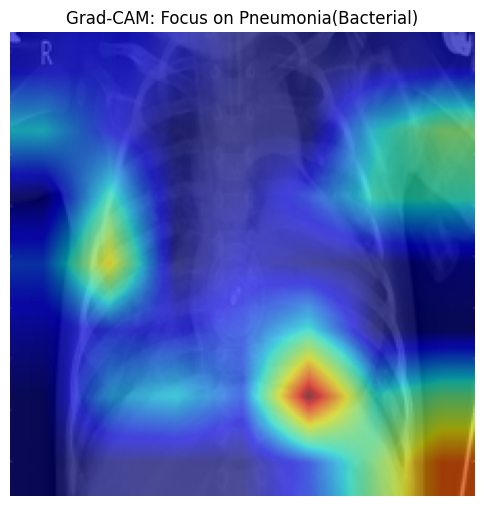

In [ ]:
# test pneumonia bacteria image 
pneumonia_bacteria = '../Kaggle/chest_xray/chest_xray/test/PNEUMONIA/person85_bacteria_417.jpeg'
raw_image = Image.open(pneumonia_bacteria).convert("RGB")

# input tensor
input_tensor = val_transform(raw_image).unsqueeze(0).to(device)
#heatmap 
heatmap = generate_grad_cam(model_resnet50,input_tensor, target_class=2) # class = 2 for bacteria
# display results
resized_raw_image = raw_image.resize(image_resize)
original_img_np = np.array(resized_raw_image)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(original_img_np)
plt.title("Original Image")
plt.axis('off')

plt.figure(1,2,2)
plt.imshow(original_img_np, alpha=1.0)
#overlay the heat map
plt.imshow(heatmap, alpha=0.6, cmap='jet')
plt.title(f"Grad-CAM: Focus on Pneumonia(Bacterial)")
plt.axis('off')
plt.tight_layout()
plt.show()